# PCA - Credit Risk Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Data Preprocessing

In [2]:
df: pd.DataFrame = pd.read_csv('credit_risk_dataset.txt')
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


### Missing Value Imputation

In [3]:
print(df.isnull().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [4]:
df["person_emp_length"].fillna(df["person_emp_length"].median(), inplace=True)
df["loan_int_rate"].fillna(df["loan_int_rate"].median(), inplace=True)

In [5]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.747008,6.354100,20.00,23.00,26.00,30.00,144.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,32416.0,4.768880,4.090411,0.00,2.00,4.00,7.00,123.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,32416.0,11.014662,3.083050,5.42,8.49,10.99,13.11,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [7]:
df.describe(include=['object']).T

,count,unique,top,freq
person_home_ownership,32416,4,RENT,16378
loan_intent,32416,6,EDUCATION,6411
loan_grade,32416,7,A,10703
cb_person_default_on_file,32416,2,N,26686


### Removing and Handling Outliers

In [8]:
# Remove Outliers 
df = df[df['person_age']<=100]
df = df[df['person_emp_length'] <= 60]
df = df[df['person_income']<=4e6]

### Categorical Encoding

In [9]:
# One hot encoding 
cat_cols = pd.DataFrame(df[df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [10]:
encoded_cat_cols = pd.get_dummies(cat_cols)
df.drop(df.select_dtypes(include=['object']).columns, axis=1,inplace=True)
df = pd.concat([df,encoded_cat_cols], axis=1)

### Standardizing

In [11]:
from sklearn.preprocessing import StandardScaler
con_vars = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
            'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
scaler = StandardScaler()
df[con_vars]=scaler.fit_transform(df[con_vars])
df

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,-1.083796,-1.071924,0.059888,-1.359401,0.040702,0,-0.657856,-0.939218,0,0,...,0,0,1,0,0,0,0,0,1,0
2,-0.439710,-1.071924,-0.944205,-0.647465,0.601834,1,3.743580,-0.692782,1,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.761753,-0.007508,-0.191135,4.019675,1.367308,1,3.368990,-0.939218,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-0.600732,-0.218867,0.812958,4.019675,1.055929,1,3.556285,-0.446345,0,0,...,0,0,0,1,0,0,0,0,0,1
5,-1.083796,-1.066211,-0.693182,-1.122089,-1.256711,1,0.746857,-0.939218,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,4.712979,-0.245525,-0.944205,-0.600002,0.695896,0,-0.564209,5.961011,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,4.229914,1.030250,-0.191135,1.270809,-1.143188,0,-0.189618,3.250207,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,6.001151,0.192427,-0.442158,4.019675,-0.007951,1,2.713457,5.468137,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,4.551957,1.601493,0.059888,0.855513,0.150983,0,-0.657856,4.975264,1,0,...,0,0,1,0,0,0,0,0,1,0


### Train-Test Split

In [12]:
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(1, test_size=0.1)
train_idx, test_idx = next(split.split(X, y))
train_x = X[train_idx]
test_x = X[test_idx]

train_y = y[train_idx]
test_y = y[test_idx]

## **PCA for Dimensionality Reduction**

In [14]:
from sklearn.decomposition import PCA
pca = PCA(0.9)
pca.fit(X)
pca.n_components_

11

In [15]:
pca = PCA()
pca.fit(X)

PCA()

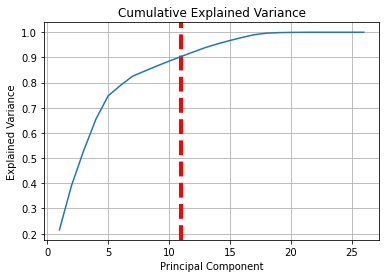

In [16]:
cumsum_data = np.cumsum(pca.explained_variance_ratio_)
x_tick = np.arange(1,len(cumsum_data)+1, 1)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=11, ymin=0, ymax=1)
plt.grid(True)
plt.plot(x_tick, cumsum_data)

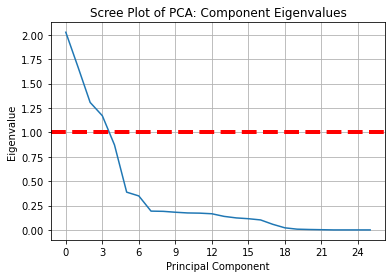

In [17]:
def scree_plot():
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.grid(True)
    plt.axhline(y=1, linewidth=4, linestyle = '--', color='r')
    plt.title('Scree Plot of PCA: Component Eigenvalues')
    show()

scree_plot()

In [18]:
covariance_matrix = np.cov(X.T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print("Eigenvector: \n",eigen_vectors,"\n")
print("Eigenvalues: \n", eigen_values, "\n")
# Calculating the explained variance on each of components
variance_explained = []
for i in eigen_values:
     variance_explained.append((i/sum(eigen_values))*100)
        
print(variance_explained)

Eigenvector: 
 [[-6.40237868e-01 -3.00906164e-02 -2.62350300e-01 -1.05380929e-01
   7.07966858e-02 -1.89830884e-02  2.89228574e-03 -7.44185589e-03
   4.25556476e-02  6.24688958e-03 -1.30710763e-02  1.31731831e-02
  -2.21479788e-03  5.30797902e-02  6.00046369e-01 -3.70228052e-01
   4.08141420e-02  1.36801770e-03  3.02564807e-03 -1.56076521e-03
  -6.07879213e-04  2.99021366e-04 -6.23796963e-17  4.09228044e-17
  -1.55079871e-17 -2.01911479e-17]
 [-2.82948565e-01 -1.51597076e-02  5.74500049e-01  4.16697171e-01
   4.08690536e-01  2.09593412e-01 -1.19935568e-01 -1.30462753e-01
  -3.82237916e-01  9.85375896e-02 -2.71120753e-02 -8.73249394e-02
   9.05535944e-02  1.79136282e-02  6.71878122e-03 -9.36244175e-04
  -3.02006143e-02 -1.58064836e-03 -8.77009001e-04  7.85384476e-04
   1.29107605e-03  5.85241254e-04  1.95376008e-17  2.30247731e-17
   6.83589843e-18  6.52917682e-17]
 [-2.74028946e-01 -2.10502755e-02  3.79118830e-01 -1.21028951e-03
  -8.60119240e-01  1.86728001e-01 -7.02207159e-02  1.0623

21.4% of the variance on our data is explained by the first principal component, the second principal component explains 17.7% of data.

### Comparing PCA Number of Components with ML Algorithms for Classification

In [19]:
accuracy_logistic=[]
accuracy_rf=[]
accuracy_xgb=[]
f = []

for i in range(10):
       f.append(i+2)

for i in f:
    pca = PCA(n_components=i)
    pca.fit(train_x)
    train_xx = pca.transform(train_x)
    test_xx = pca.transform(test_x)
    
    logisticRegr = LogisticRegression(solver = 'lbfgs')
    logisticRegr.fit(train_xx, train_y)
    log_score=logisticRegr.score(test_xx, test_y)
    accuracy_logistic.append(log_score)
    
    pca.fit(train_x)
    train_xxx = pca.transform(train_x)
    test_xxx = pca.transform(test_x)
    
    rf = RandomForestClassifier()
    rf.fit(train_xxx, train_y)
    y_pred = rf.predict(test_xxx)
    rf_score=accuracy_score(test_y, y_pred)
    accuracy_rf.append(rf_score)
    
    pca = PCA(n_components=4)
    pca.fit(train_x)
    train_xg = pca.transform(train_x)
    test_xg = pca.transform(test_x)

    xgb = XGBClassifier()
    xgb.fit(train_xg,train_y)
    # make predictions for test data
    pred_y = xgb.predict(test_xg)
    xgb_score = accuracy_score(test_y, pred_y)
    accuracy_xgb.append(xgb_score)


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


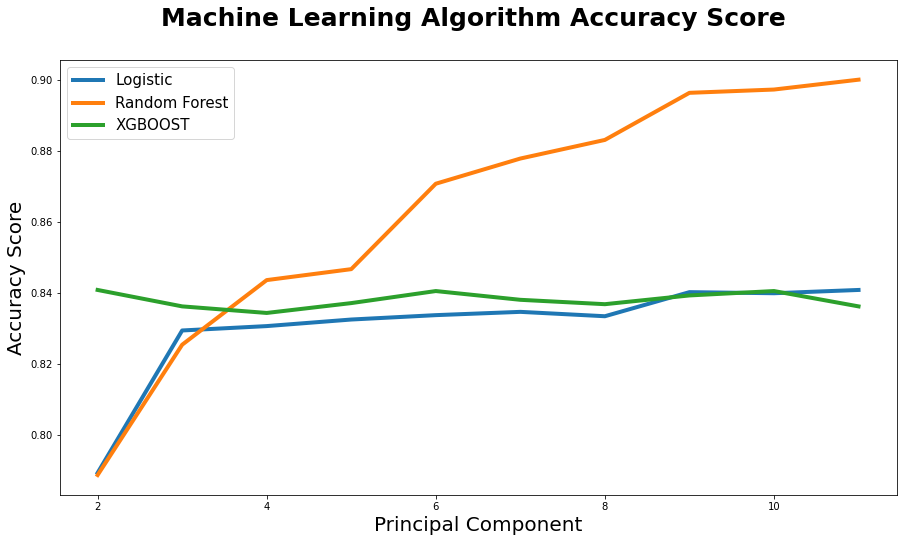

In [20]:
from numpy import *
import math
import matplotlib.pyplot as plt

t = linspace(2,11,10)

plt.subplots(figsize =(15, 8))
plt.plot(t, accuracy_logistic, t, accuracy_rf, t, accuracy_xgb, linewidth=4)
plt.title('Machine Learning Algorithm Accuracy Score \n', fontsize=25, fontweight='bold')
plt.xlabel('Principal Component', fontsize=20)
plt.ylabel('Accuracy Score', fontsize=20)
plt.legend(["Logistic", "Random Forest", "XGBOOST"], fontsize=15)
plt.show()

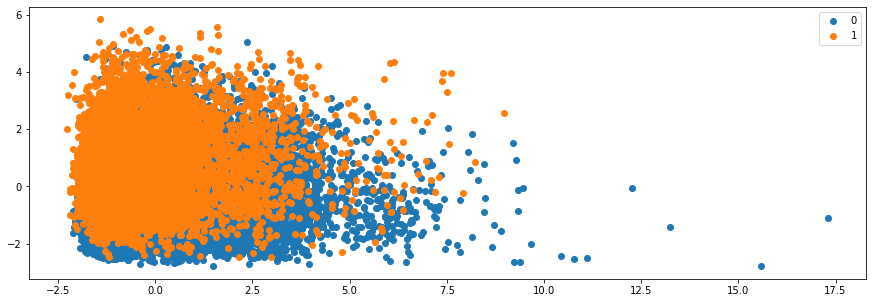

In [21]:
pca = PCA(n_components=4)
X2D = pca.fit_transform(X,y)
figure = plt.figure(1,(15,5))
for label in set(y):
    data = X2D[y==label]
    plt.scatter(data[:,0], data[:,1],label=label)
plt.legend()
plt.show()